Importing essential liberaries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Uploading dataset


In [3]:
from google.colab import files
uploaded = files.upload()

Saving UK Train Rides new.csv to UK Train Rides new.csv


In [4]:
df = pd.read_csv('UK Train Rides new.csv', dtype=str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31653 entries, 0 to 31652
Data columns (total 1 columns):
 #   Column                                                                                                                                                                                                                                                     Non-Null Count  Dtype 
---  ------                                                                                                                                                                                                                                                     --------------  ----- 
 0   Transaction ID;Date of Purchase;Time of Purchase;Purchase Type;Payment Method;Railcard;Ticket Class;Ticket Type;Price;Departure Station;Arrival Destination;Date of Journey;Departure Time;Arrival Time;Actual Arrival Time;Journey Status;Refund Request  31653 non-null  object
dtypes: object(1)
memory usage: 247.4+ KB


Clean and Convert Columns

In [5]:
print("Shape (rows, cols):", df.shape)
display(df.head(10))
display(df.info())
display(df.describe(include='all').T)


Shape (rows, cols): (31653, 1)


,Transaction ID;Date of Purchase;Time of Purchase;Purchase Type;Payment Method;Railcard;Ticket Class;Ticket Type;Price;Departure Station;Arrival Destination;Date of Journey;Departure Time;Arrival Time;Actual Arrival Time;Journey Status;Refund Request
0,da8a6ba8-b3dc-4677-b176;08/12/2023;12:41:11;On...
1,b0cdd1b0-f214-4197-be53;16/12/2023;11:23:01;St...
2,f3ba7a96-f713-40d9-9629;19/12/2023;19:51:27;On...
3,b2471f11-4fe7-4c87-8ab4;20/12/2023;23:00:36;St...
4,2be00b45-0762-485e-a7a3;27/12/2023;18:22:56;On...
5,4e1dcd88-3d95-44ef-99fa;30/12/2023;07:56:06;On...
6,1c74479d-85a4-4ba1-a607;31/12/2023;00:02:01;St...
7,febf8dab-f808-46fa-bf2b;31/12/2023;01:35:18;St...
8,01df916f-4291-41ec-a37d;31/12/2023;01:43:09;St...
9,a8cedba7-1923-459d-b046;31/12/2023;03:05:52;On...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31653 entries, 0 to 31652
Data columns (total 1 columns):
 #   Column                                                                                                                                                                                                                                                     Non-Null Count  Dtype 
---  ------                                                                                                                                                                                                                                                     --------------  ----- 
 0   Transaction ID;Date of Purchase;Time of Purchase;Purchase Type;Payment Method;Railcard;Ticket Class;Ticket Type;Price;Departure Station;Arrival Destination;Date of Journey;Departure Time;Arrival Time;Actual Arrival Time;Journey Status;Refund Request  31653 non-null  object
dtypes: object(1)
memory usage: 247.4+ KB


None

,count,unique,top,freq
Transaction ID;Date of Purchase;Time of Purchase;Purchase Type;Payment Method;Railcard;Ticket Class;Ticket Type;Price;Departure Station;Arrival Destination;Date of Journey;Departure Time;Arrival Time;Actual Arrival Time;Journey Status;Refund Request,31653,31653,1d5d89a2-bde5-410f-8f91;30/04/2024;20:05:39;St...,1


In [6]:
df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('/', '_').str.lower()
print(df.columns.tolist())


['transaction_id;date_of_purchase;time_of_purchase;purchase_type;payment_method;railcard;ticket_class;ticket_type;price;departure_station;arrival_destination;date_of_journey;departure_time;arrival_time;actual_arrival_time;journey_status;refund_request']


In [9]:
# Split the single column into multiple columns using semicolon as delimiter
df = df['transaction_id;date_of_purchase;time_of_purchase;purchase_type;payment_method;railcard;ticket_class;ticket_type;price;departure_station;arrival_destination;date_of_journey;departure_time;arrival_time;actual_arrival_time;journey_status;refund_request'].str.split(';', expand=True)

# Assign new column names
df.columns = ['transaction_id', 'date_of_purchase', 'time_of_purchase', 'purchase_type', 'payment_method', 'railcard', 'ticket_class', 'ticket_type', 'price', 'departure_station', 'arrival_destination', 'date_of_journey', 'departure_time', 'arrival_time', 'actual_arrival_time', 'journey_status', 'refund_request']

# Convert date columns
df['date_of_purchase'] = pd.to_datetime(df['date_of_purchase'], dayfirst=True, errors='coerce')
df['date_of_journey']  = pd.to_datetime(df['date_of_journey'], dayfirst=True, errors='coerce')

# Convert time columns
for tcol in ['time_of_purchase','departure_time','arrival_time','actual_arrival_time']:
    if tcol in df.columns:
        # Attempt to convert time to datetime.time object, coercing errors
        df[tcol] = pd.to_datetime(df[tcol], format='%H:%M:%S', errors='coerce').dt.time

print("Null dates after convert:", df[['date_of_purchase','date_of_journey']].isna().sum().to_dict())

Null dates after convert: {'date_of_purchase': 0, 'date_of_journey': 0}


In [11]:
from datetime import datetime, timedelta

def combine_dt(row, date_col, time_col):
    date = row[date_col]
    t = row[time_col]
    if pd.isna(date) or pd.isna(t):
        return pd.NaT
    return pd.Timestamp.combine(date.date(), t)

df['departure_dt'] = df.apply(lambda r: combine_dt(r,'date_of_journey','departure_time'), axis=1)
df['arrival_dt']   = df.apply(lambda r: combine_dt(r,'date_of_journey','arrival_time'), axis=1)
df['actual_arrival_dt'] = df.apply(lambda r: combine_dt(r,'date_of_journey','actual_arrival_time'), axis=1)

mask = df['arrival_dt'].notna() & df['departure_dt'].notna() & (df['arrival_dt'] < df['departure_dt'])
df.loc[mask, 'arrival_dt'] = df.loc[mask, 'arrival_dt'] + pd.Timedelta(days=1)

mask2 = df['actual_arrival_dt'].notna() & df['departure_dt'].notna() & (df['actual_arrival_dt'] < df['departure_dt'])
df.loc[mask2, 'actual_arrival_dt'] = df.loc[mask2, 'actual_arrival_dt'] + pd.Timedelta(days=1)

print("cases arrival < departure (fixed):", mask.sum(), " | actual_arrival fixed:", mask2.sum())


cases arrival < departure (fixed): 961  | actual_arrival fixed: 916


Journey period and late


In [12]:

df['scheduled_duration_min'] = (df['arrival_dt'] - df['departure_dt']).dt.total_seconds() / 60
df['actual_duration_min']    = (df['actual_arrival_dt'] - df['departure_dt']).dt.total_seconds() / 60


df['arrival_delay_min'] = df['actual_duration_min'] - df['scheduled_duration_min']

df['duration_negative_flag'] = df['scheduled_duration_min'] <= 0
df['has_actual_arrival'] = df['actual_arrival_dt'].notna()
df['is_delayed_flag'] = df['arrival_delay_min'] > 0
df['long_delay'] = df['arrival_delay_min'] > 15


df['journey_dayofweek'] = df['date_of_journey'].dt.day_name()
df['journey_weekday'] = df['date_of_journey'].dt.weekday
df['departure_hour'] = df['departure_dt'].dt.hour
df['lead_days'] = (df['date_of_journey'] - df['date_of_purchase']).dt.days


display(df[['scheduled_duration_min','actual_duration_min','arrival_delay_min','duration_negative_flag']].describe())
print("Proportion with actual arrival:", df['has_actual_arrival'].mean())


,scheduled_duration_min,actual_duration_min,arrival_delay_min
count,31653.000000,29773.000000,29773.000000
mean,71.154235,74.385114,3.249689
std,36.330811,40.223175,14.770539
min,15.000000,15.000000,0.000000
25%,30.000000,30.000000,0.000000
50%,80.000000,80.000000,0.000000
75%,90.000000,90.000000,0.000000
max,270.000000,288.000000,180.000000


Proportion with actual arrival: 0.9406059457239441


Price Transformation


In [13]:

df['price'] = df['price'].astype(str).str.replace('[^0-9.]','', regex=True)
df['price'] = pd.to_numeric(df['price'], errors='coerce')

df['price_per_min'] = df['price'] / df['scheduled_duration_min']
df.loc[df['scheduled_duration_min']<=0, 'price_per_min'] = pd.NA


for col in ['purchase_type','payment_method','railcard','ticket_class','ticket_type','journey_status','refund_request']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.title().replace({'Nan':pd.NA,'None':pd.NA})


df['has_railcard'] = df['railcard'].notna()
df['refund_requested'] = df['refund_request'].str.lower().isin(['yes','y','true','1'])


Checking Quality

In [14]:
checks = {
    "total_rows": len(df),
    "negative_duration_count": int(df['duration_negative_flag'].sum()),
    "missing_actual_arrival_count": int((~df['has_actual_arrival']).sum()),
    "missing_price_count": int(df['price'].isna().sum()),
    "lead_days_negative_count": int((df['lead_days'] < 0).sum())
}
print(checks)


{'total_rows': 31653, 'negative_duration_count': 0, 'missing_actual_arrival_count': 1880, 'missing_price_count': 0, 'lead_days_negative_count': 0}


In [17]:

display(df[['price','scheduled_duration_min','arrival_delay_min','price_per_min','lead_days']].describe())


for col in ['departure_station','arrival_destination','ticket_class','purchase_type','payment_method']:
    if col in df.columns:
        print(f"Top values for {col}:")
        print(df[col].value_counts().head(10))
        print('-'*30)


,price,scheduled_duration_min,arrival_delay_min,price_per_min,lead_days
count,31653.000000,31653.000000,29773.000000,31653.000000,31653.000000
mean,23.439200,71.154235,3.249689,0.276608,1.655957
std,29.997628,36.330811,14.770539,0.251580,3.853255
min,1.000000,15.000000,0.000000,0.028571,0.000000
25%,5.000000,30.000000,0.000000,0.100000,0.000000
50%,11.000000,80.000000,0.000000,0.187500,1.000000
75%,35.000000,90.000000,0.000000,0.333333,1.000000
max,267.000000,270.000000,180.000000,2.427273,28.000000


Top values for departure_station:
departure_station
Manchester Piccadilly    5650
London Euston            4954
Liverpool Lime Street    4561
London Paddington        4500
London Kings Cross       4229
London St Pancras        3891
Birmingham New Street    2136
York                      927
Reading                   594
Oxford                    144
Name: count, dtype: int64
------------------------------
Top values for arrival_destination:
arrival_destination
Birmingham New Street    7742
Liverpool Lime Street    5022
York                     4019
Manchester Piccadilly    3968
Reading                  3920
London Euston            1567
London St Pancras         749
Oxford                    623
London Paddington         351
Leicester                 337
Name: count, dtype: int64
------------------------------
Top values for ticket_class:
ticket_class
Standard       28595
First Class     3058
Name: count, dtype: int64
------------------------------
Top values for purchase_type:
purchas

Delay By Hour

In [18]:
delay_by_hour = df.groupby('departure_hour')['arrival_delay_min'].agg(['count','mean','median']).reset_index().sort_values('departure_hour')
display(delay_by_hour)


,departure_hour,count,mean,median
0,0,804,0.768657,0.0
1,1,621,0.771337,0.0
2,2,878,0.000000,0.0
3,3,532,5.648496,0.0
4,4,995,0.293467,0.0
5,5,703,1.524893,0.0
6,6,2925,1.008547,0.0
7,7,2541,0.072412,0.0
8,8,2031,14.913343,0.0
9,9,1185,12.888608,0.0


In [19]:
topN = 15
delay_by_station = df.groupby('departure_station').agg(total_trips=('transaction_id','count'),
                                                      mean_delay=('arrival_delay_min','mean'),
                                                      delay_rate=('is_delayed_flag','mean')).reset_index()
delay_by_station = delay_by_station.sort_values('total_trips', ascending=False).head(topN)
display(delay_by_station)


,departure_station,total_trips,mean_delay,delay_rate
8,Manchester Piccadilly,5650,7.409747,0.117345
4,London Euston,4954,2.962537,0.052281
3,Liverpool Lime Street,4561,7.248902,0.196448
6,London Paddington,4500,0.567463,0.014667
5,London Kings Cross,4229,0.524248,0.030504
7,London St Pancras,3891,0.000000,0.000000
0,Birmingham New Street,2136,1.931773,0.064607
11,York,927,2.910345,0.061489
10,Reading,594,0.000000,0.000000
9,Oxford,144,2.094203,0.104167


Average delay by departure hour and ticket class

In [20]:
pivot = df.pivot_table(index='departure_hour', columns='ticket_class', values='arrival_delay_min', aggfunc='mean')
display(pivot)


ticket_class,First Class,Standard
departure_hour,,
0,0.500000,0.803371
1,0.209677,0.833631
2,0.000000,0.000000
3,3.928571,5.795918
4,0.277108,0.294956
5,2.833333,1.402799
6,1.174377,0.990923
7,0.033755,0.076389
8,14.609137,14.946020


Average price over each class


In [25]:
# Calculate and display the average price for each ticket class
price_by_class = df.groupby('ticket_class')['price'].mean().reset_index()
print("Average price by ticket class:")
display(price_by_class)

Average price by ticket class:


,ticket_class,price
0,First Class,48.855134
1,Standard,20.721175


Analyze how purchase type (Online vs. Station) relates to factors like price, delays, or journey status.

In [26]:
# Analyze metrics by purchase type
purchase_type_analysis = df.groupby('purchase_type')[['price', 'arrival_delay_min', 'lead_days']].mean().reset_index()
print("Analysis by Purchase Type:")
display(purchase_type_analysis)

# You can also look at the distribution of journey status by purchase type
print("\nJourney Status Distribution by Purchase Type:")
display(pd.crosstab(df['purchase_type'], df['journey_status'], normalize='index'))

Analysis by Purchase Type:


,purchase_type,price,arrival_delay_min,lead_days
0,Online,20.665947,0.370831,1.685384
1,Station,27.350518,7.242104,1.614453



Journey Status Distribution by Purchase Type:


journey_status,Cancelled,Delayed,On Time
purchase_type,,,
Online,0.065979,0.011177,0.922844
Station,0.050107,0.158772,0.791121


In [28]:
# Analyze payment method usage
payment_method_counts = df['payment_method'].value_counts().reset_index()
payment_method_counts.columns = ['Payment Method', 'Count']
print("Distribution of Payment Methods:")
display(payment_method_counts)

# Optional: Analyze other metrics by payment method
payment_method_analysis = df.groupby('payment_method')[['price', 'arrival_delay_min', 'lead_days']].mean().reset_index()
print("\nAnalysis by Payment Method:")
display(payment_method_analysis)

Distribution of Payment Methods:


,Payment Method,Count
0,Credit Card,19136
1,Contactless,10834
2,Debit Card,1683



Analysis by Payment Method:


,payment_method,price,arrival_delay_min,lead_days
0,Contactless,20.255123,2.717036,1.674082
1,Credit Card,24.535483,3.070969,1.657452
2,Debit Card,31.471182,8.643657,1.522282


Analyze the impact of using a railcard on price and potentially other metrics.

In [29]:
# Analyze metrics by railcard usage
railcard_analysis = df.groupby('has_railcard')[['price', 'arrival_delay_min', 'lead_days']].mean().reset_index()
print("Analysis by Railcard Usage:")
display(railcard_analysis)

# You can also look at the distribution of journey status by railcard usage
print("\nJourney Status Distribution by Railcard Usage:")
display(pd.crosstab(df['has_railcard'], df['journey_status'], normalize='index'))

Analysis by Railcard Usage:


,has_railcard,price,arrival_delay_min,lead_days
0,False,27.425997,3.055787,1.671527
1,True,15.670610,3.625852,1.625617



Journey Status Distribution by Railcard Usage:


journey_status,Cancelled,Delayed,On Time
has_railcard,,,
False,0.060809,0.067406,0.871785
True,0.056637,0.082161,0.861202


Deep dive into journey statuses (On Time, Delayed, Cancelled) and analyze factors contributing to delays, such as departure station, time of day, or day of the week.

In [30]:
# Analyze delay by day of the week
delay_by_day = df.groupby('journey_dayofweek')['arrival_delay_min'].agg(['count', 'mean', 'median']).reset_index()
# Define the order of the days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
delay_by_day['journey_dayofweek'] = pd.Categorical(delay_by_day['journey_dayofweek'], categories=day_order, ordered=True)
delay_by_day = delay_by_day.sort_values('journey_dayofweek')

print("Delay analysis by day of the week:")
display(delay_by_day)

# You can also analyze the distribution of journey status by day of the week
print("\nJourney Status Distribution by Day of the Week:")
display(pd.crosstab(df['journey_dayofweek'], df['journey_status'], normalize='index'))

Delay analysis by day of the week:


,journey_dayofweek,count,mean,median
1,Monday,4181,3.060512,0.0
5,Tuesday,4311,3.327766,0.0
6,Wednesday,4403,3.208040,0.0
4,Thursday,4338,3.610420,0.0
0,Friday,4140,3.237198,0.0
2,Saturday,4117,3.113189,0.0
3,Sunday,4283,3.176512,0.0



Journey Status Distribution by Day of the Week:


journey_status,Cancelled,Delayed,On Time
journey_dayofweek,,,
Friday,0.048495,0.070788,0.880717
Monday,0.057484,0.071235,0.871280
Saturday,0.065804,0.066258,0.867937
Sunday,0.064847,0.065939,0.869214
Thursday,0.052838,0.084716,0.862445
Tuesday,0.064250,0.075971,0.859779
Wednesday,0.061594,0.071611,0.866795


Analyze trends over time, such as the number of journeys, average price, or delay rates over months or days of the week.

In [31]:
# Extract month and year for time series analysis
df['year_month'] = df['date_of_journey'].dt.to_period('M')

# Analyze trends by month
time_series_analysis = df.groupby('year_month').agg(
    total_journeys=('transaction_id', 'count'),
    average_price=('price', 'mean'),
    average_delay=('arrival_delay_min', 'mean')
).reset_index()

# Convert 'year_month' back to string for display
time_series_analysis['year_month'] = time_series_analysis['year_month'].astype(str)

print("Time Series Analysis by Month:")
display(time_series_analysis)

Time Series Analysis by Month:


,year_month,total_journeys,average_price,average_delay
0,2024-01,8111,24.610775,3.314694
1,2024-02,7644,20.849555,3.178453
2,2024-03,8117,24.041764,3.418525
3,2024-04,7781,24.133402,3.075859


Visualizing Delay

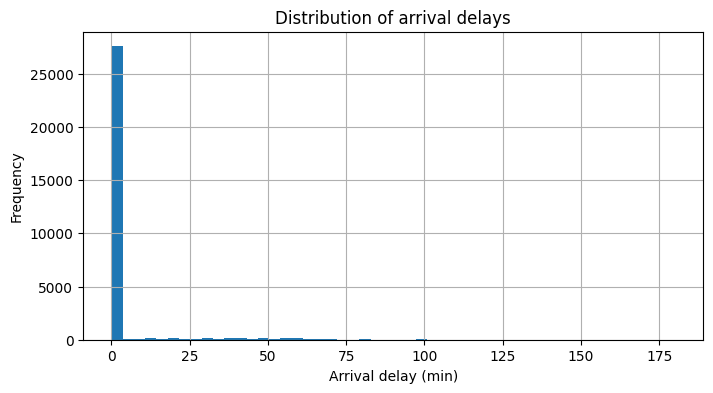

In [21]:
plt.figure(figsize=(8,4))
df['arrival_delay_min'].dropna().hist(bins=50)
plt.xlabel('Arrival delay (min)')
plt.ylabel('Frequency')
plt.title('Distribution of arrival delays')
plt.show()

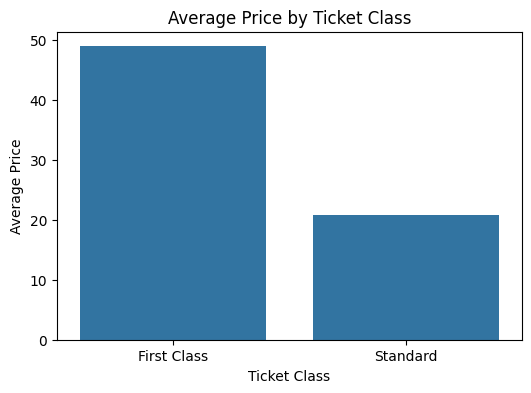

In [32]:
# Create a bar chart for average price by ticket class
plt.figure(figsize=(6, 4))
sns.barplot(x='ticket_class', y='price', data=price_by_class)
plt.title('Average Price by Ticket Class')
plt.xlabel('Ticket Class')
plt.ylabel('Average Price')
plt.show()

### Visualizations for Purchase Type Analysis

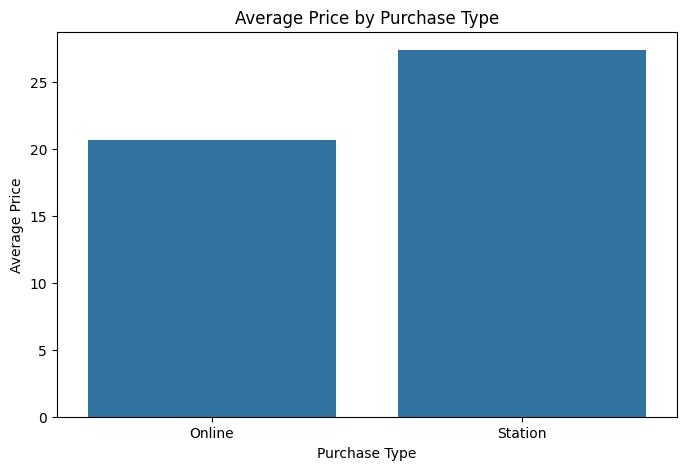

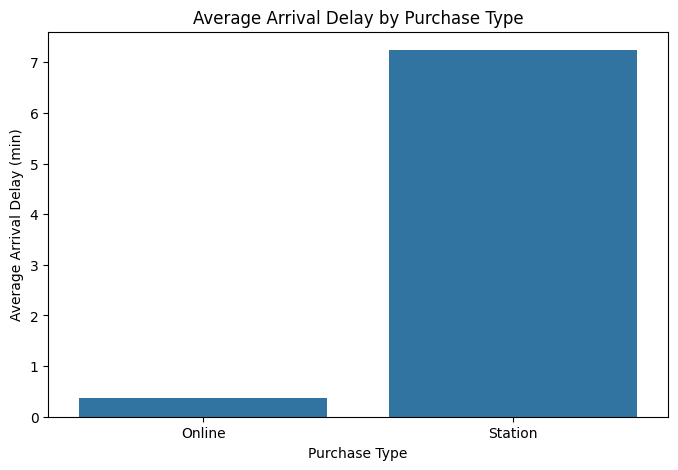

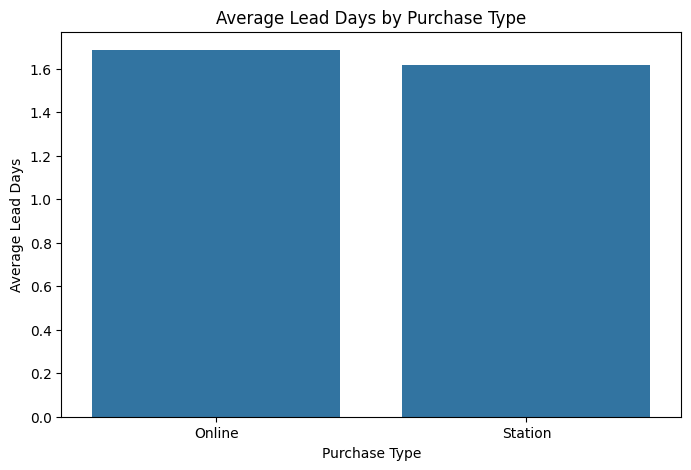

<Figure size 800x500 with 0 Axes>

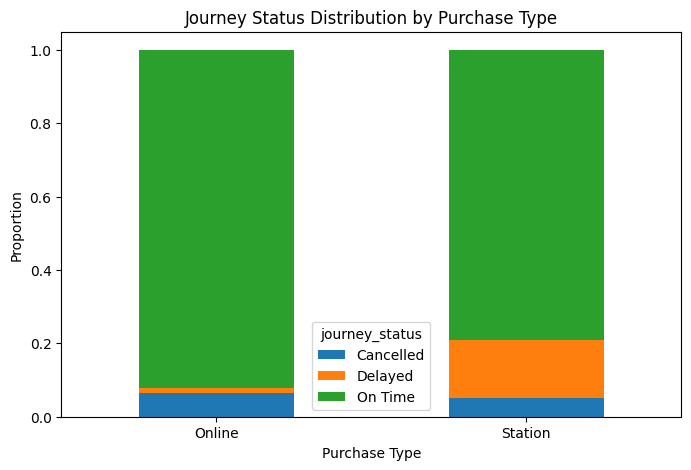

In [33]:
# Bar chart for average price by purchase type
plt.figure(figsize=(8, 5))
sns.barplot(x='purchase_type', y='price', data=purchase_type_analysis)
plt.title('Average Price by Purchase Type')
plt.xlabel('Purchase Type')
plt.ylabel('Average Price')
plt.show()

# Bar chart for average arrival delay by purchase type
plt.figure(figsize=(8, 5))
sns.barplot(x='purchase_type', y='arrival_delay_min', data=purchase_type_analysis)
plt.title('Average Arrival Delay by Purchase Type')
plt.xlabel('Purchase Type')
plt.ylabel('Average Arrival Delay (min)')
plt.show()

# Bar chart for average lead days by purchase type
plt.figure(figsize=(8, 5))
sns.barplot(x='purchase_type', y='lead_days', data=purchase_type_analysis)
plt.title('Average Lead Days by Purchase Type')
plt.xlabel('Purchase Type')
plt.ylabel('Average Lead Days')
plt.show()

# Stacked bar chart for Journey Status Distribution by Purchase Type
plt.figure(figsize=(8, 5))
purchase_status_pivot = pd.crosstab(df['purchase_type'], df['journey_status'], normalize='index')
purchase_status_pivot.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.title('Journey Status Distribution by Purchase Type')
plt.xlabel('Purchase Type')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.show()

### Visualizations for Payment Method Usage

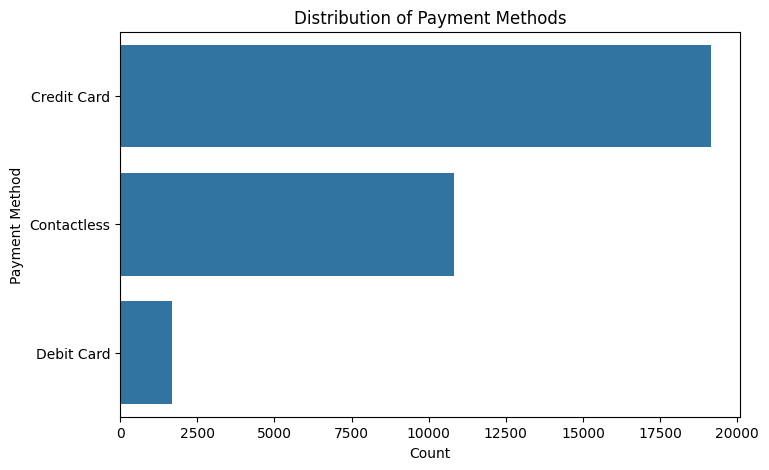

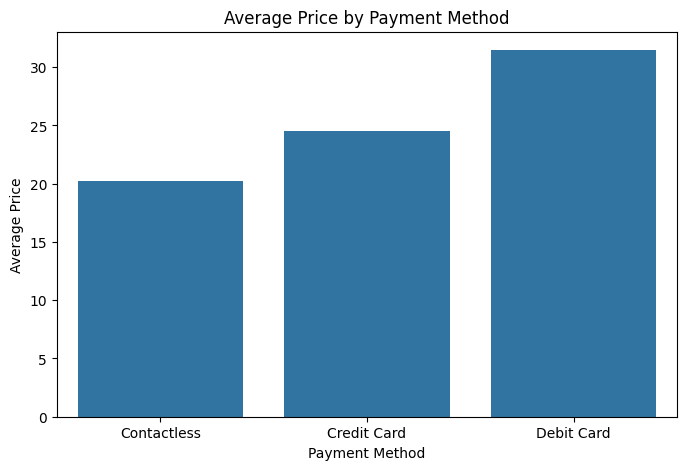

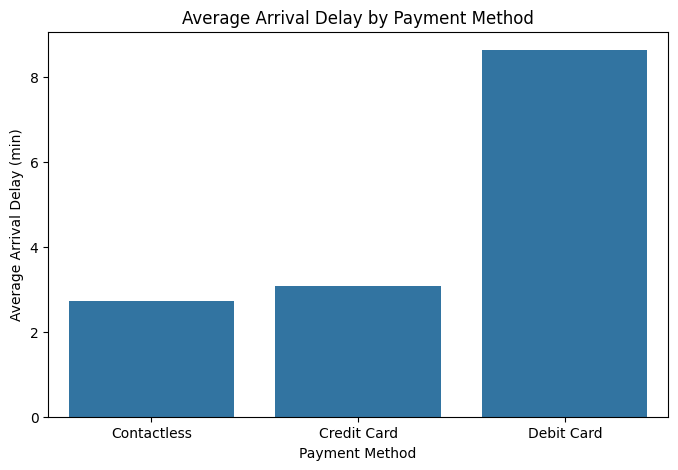

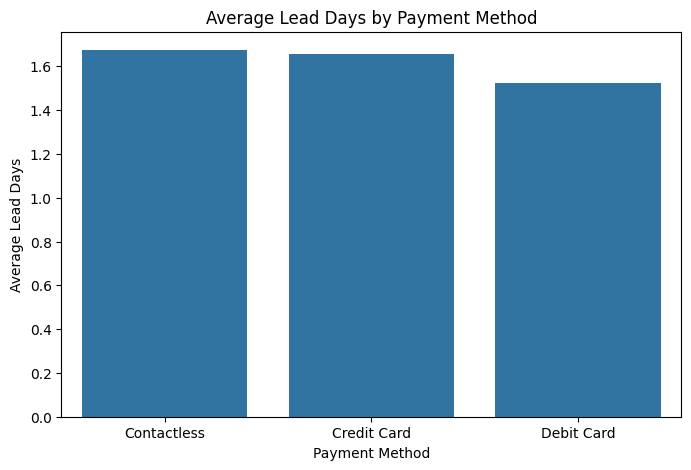

In [34]:
# Bar chart for distribution of payment methods
plt.figure(figsize=(8, 5))
sns.countplot(y='payment_method', data=df, order=df['payment_method'].value_counts().index)
plt.title('Distribution of Payment Methods')
plt.xlabel('Count')
plt.ylabel('Payment Method')
plt.show()

# Bar charts for analysis by payment method (if payment_method_analysis DataFrame exists)
if 'payment_method_analysis' in locals():
    plt.figure(figsize=(8, 5))
    sns.barplot(x='payment_method', y='price', data=payment_method_analysis)
    plt.title('Average Price by Payment Method')
    plt.xlabel('Payment Method')
    plt.ylabel('Average Price')
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.barplot(x='payment_method', y='arrival_delay_min', data=payment_method_analysis)
    plt.title('Average Arrival Delay by Payment Method')
    plt.xlabel('Payment Method')
    plt.ylabel('Average Arrival Delay (min)')
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.barplot(x='payment_method', y='lead_days', data=payment_method_analysis)
    plt.title('Average Lead Days by Payment Method')
    plt.xlabel('Payment Method')
    plt.ylabel('Average Lead Days')
    plt.show()

### Visualizations for Railcard Impact

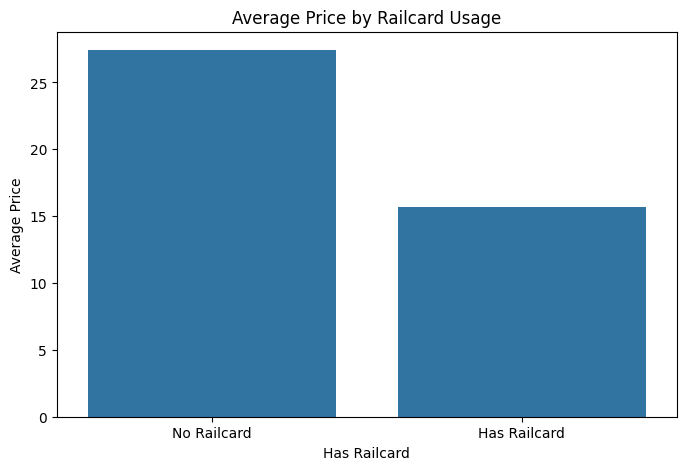

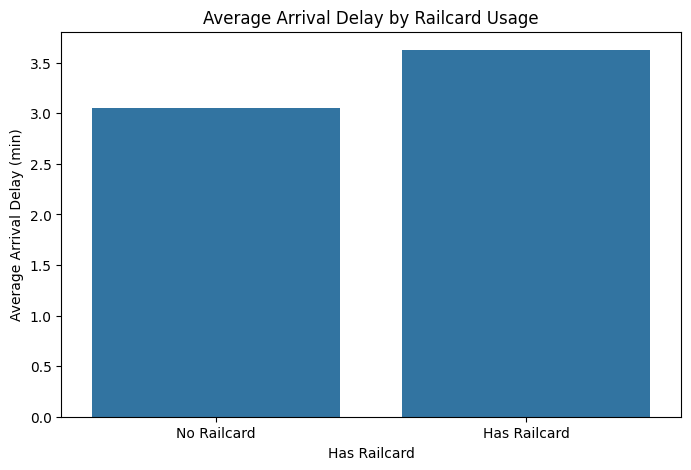

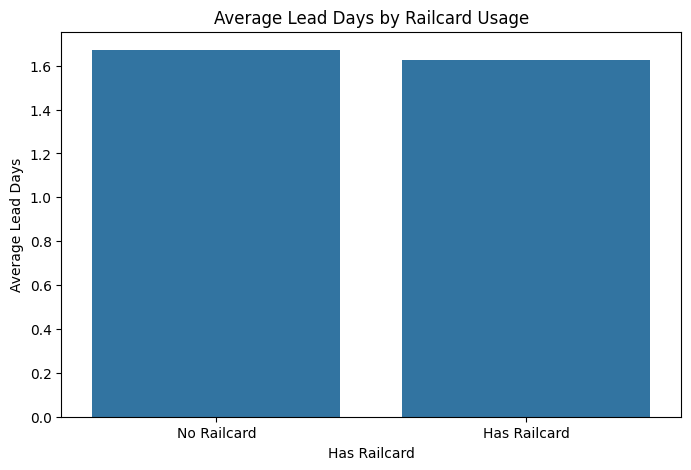

<Figure size 800x500 with 0 Axes>

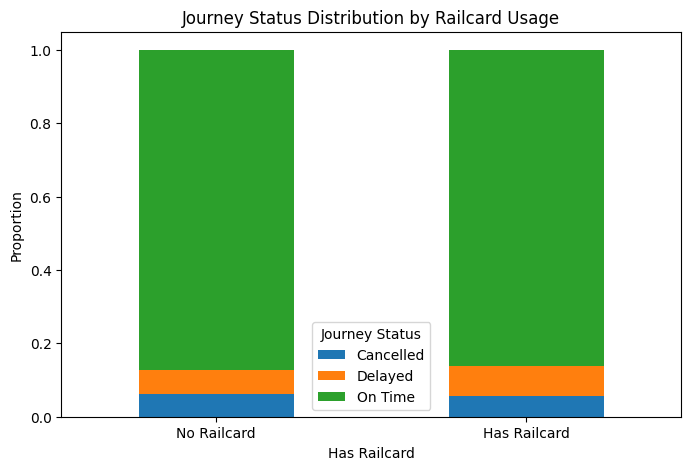

In [35]:
# Bar chart for average price by railcard usage
plt.figure(figsize=(8, 5))
sns.barplot(x='has_railcard', y='price', data=railcard_analysis)
plt.title('Average Price by Railcard Usage')
plt.xlabel('Has Railcard')
plt.ylabel('Average Price')
plt.xticks([0, 1], ['No Railcard', 'Has Railcard'])
plt.show()

# Bar chart for average arrival delay by railcard usage
plt.figure(figsize=(8, 5))
sns.barplot(x='has_railcard', y='arrival_delay_min', data=railcard_analysis)
plt.title('Average Arrival Delay by Railcard Usage')
plt.xlabel('Has Railcard')
plt.ylabel('Average Arrival Delay (min)')
plt.xticks([0, 1], ['No Railcard', 'Has Railcard'])
plt.show()

# Bar chart for average lead days by railcard usage
plt.figure(figsize=(8, 5))
sns.barplot(x='has_railcard', y='lead_days', data=railcard_analysis)
plt.title('Average Lead Days by Railcard Usage')
plt.xlabel('Has Railcard')
plt.ylabel('Average Lead Days')
plt.xticks([0, 1], ['No Railcard', 'Has Railcard'])
plt.show()

# Stacked bar chart for Journey Status Distribution by Railcard Usage
plt.figure(figsize=(8, 5))
railcard_status_pivot = pd.crosstab(df['has_railcard'], df['journey_status'], normalize='index')
railcard_status_pivot.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.title('Journey Status Distribution by Railcard Usage')
plt.xlabel('Has Railcard')
plt.ylabel('Proportion')
plt.xticks([0, 1], ['No Railcard', 'Has Railcard'], rotation=0)
plt.legend(title='Journey Status')
plt.show()

### Visualizations for Journey Status and Delays

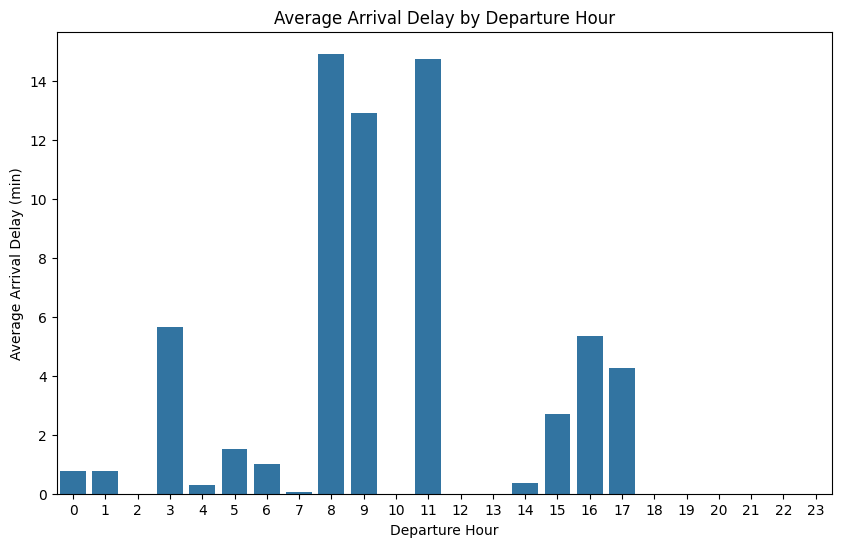

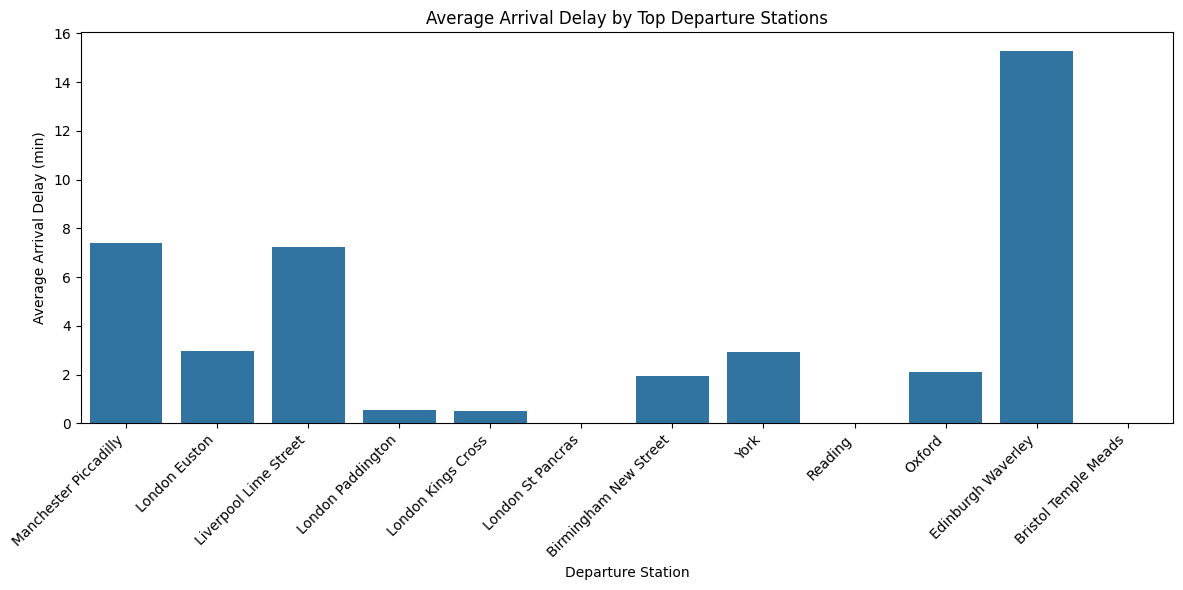

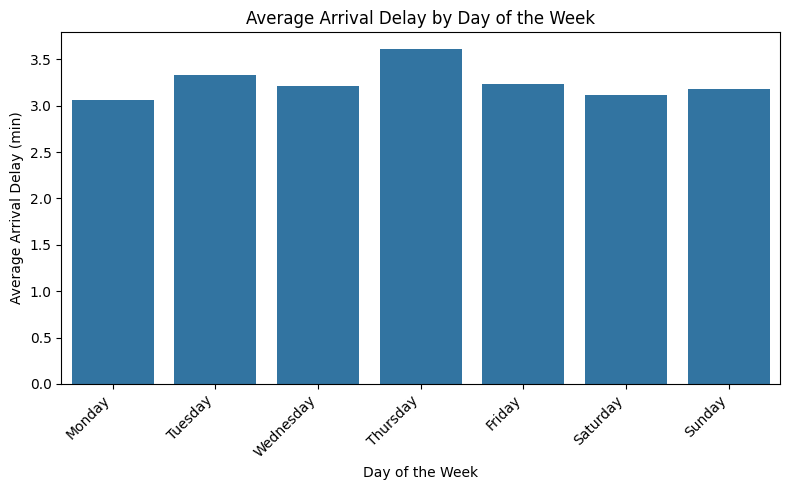

<Figure size 1000x600 with 0 Axes>

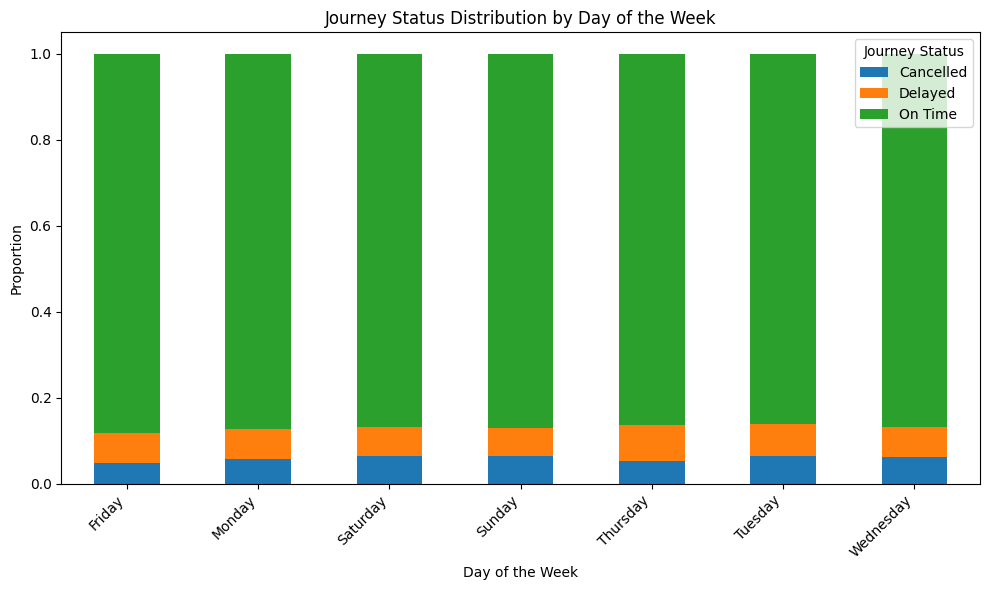

In [36]:
# Bar chart for average delay by departure hour
plt.figure(figsize=(10, 6))
sns.barplot(x='departure_hour', y='mean', data=delay_by_hour)
plt.title('Average Arrival Delay by Departure Hour')
plt.xlabel('Departure Hour')
plt.ylabel('Average Arrival Delay (min)')
plt.xticks(rotation=0)
plt.show()

# Bar chart for average delay by top departure stations
plt.figure(figsize=(12, 6))
sns.barplot(x='departure_station', y='mean_delay', data=delay_by_station)
plt.title('Average Arrival Delay by Top Departure Stations')
plt.xlabel('Departure Station')
plt.ylabel('Average Arrival Delay (min)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Bar chart for average delay by day of the week
plt.figure(figsize=(8, 5))
sns.barplot(x='journey_dayofweek', y='mean', data=delay_by_day)
plt.title('Average Arrival Delay by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Arrival Delay (min)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Stacked bar chart for Journey Status Distribution by Day of the Week
plt.figure(figsize=(10, 6))
day_status_pivot = pd.crosstab(df['journey_dayofweek'], df['journey_status'], normalize='index')
day_status_pivot.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Journey Status Distribution by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Proportion')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Journey Status')
plt.tight_layout()
plt.show()

### Visualizations for Time Series Analysis

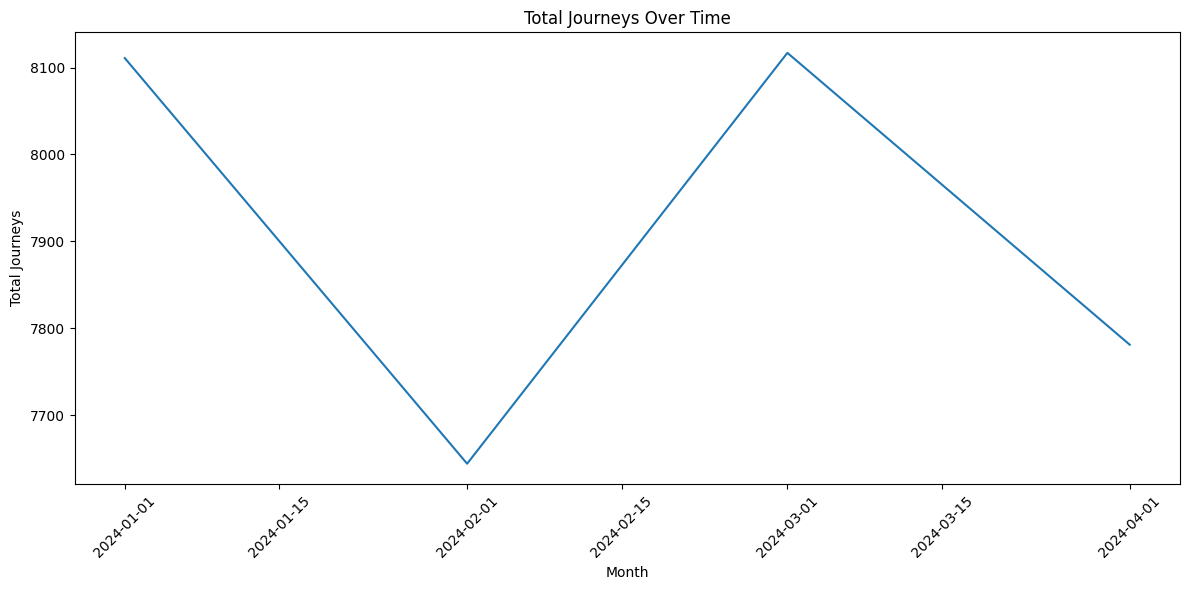

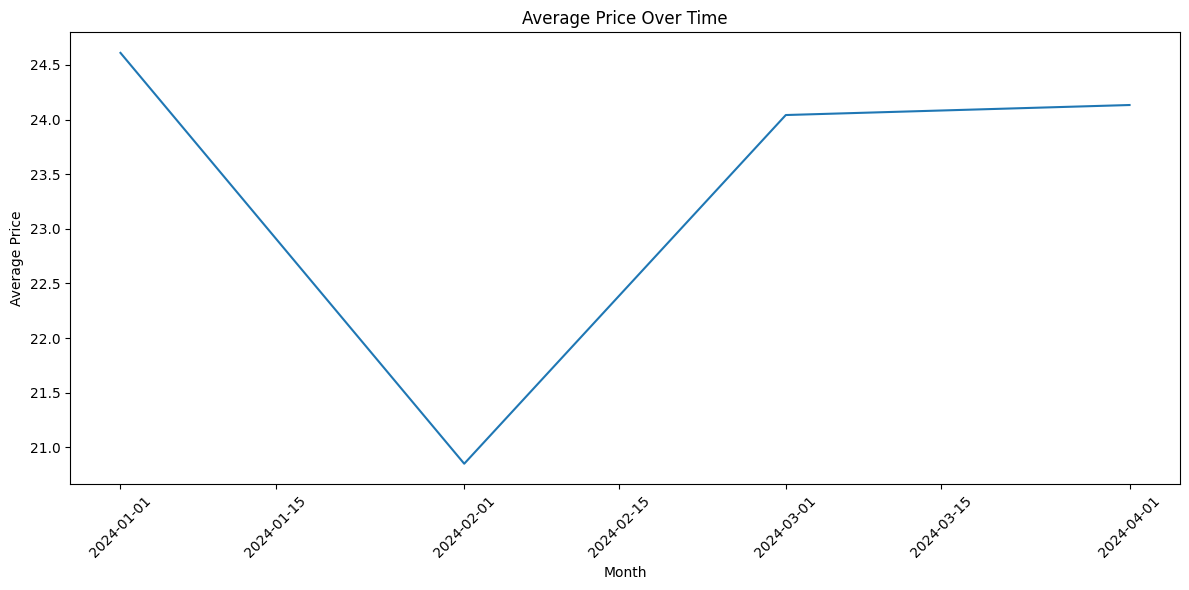

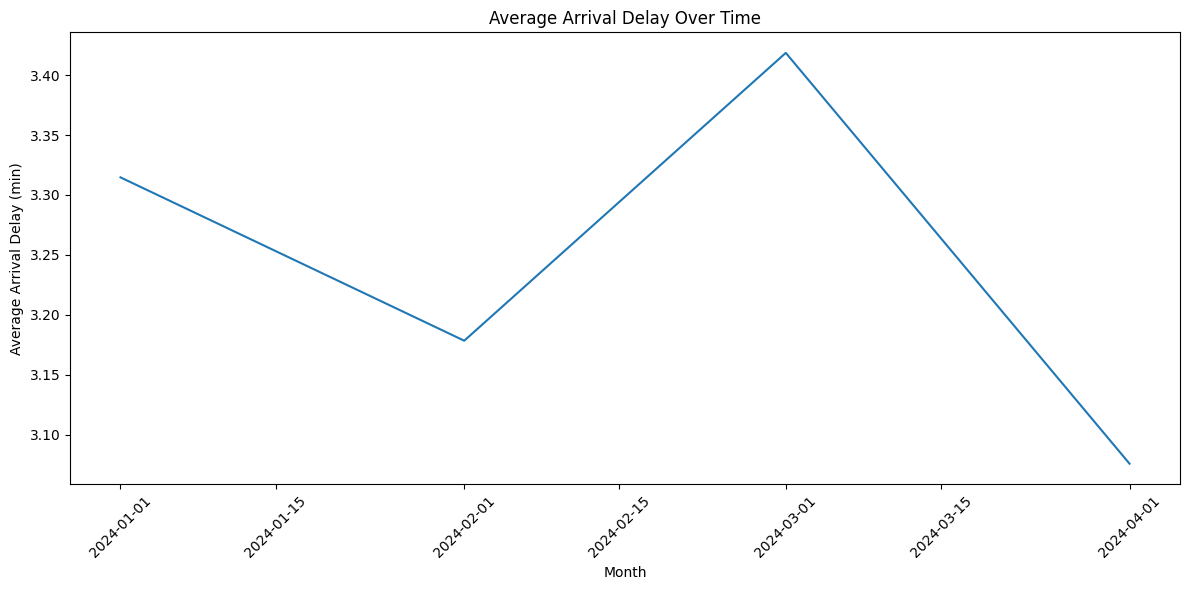

In [37]:
# Convert 'year_month' back to datetime for plotting
time_series_analysis['year_month'] = pd.to_datetime(time_series_analysis['year_month'])

# Line plot for total journeys over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='year_month', y='total_journeys', data=time_series_analysis)
plt.title('Total Journeys Over Time')
plt.xlabel('Month')
plt.ylabel('Total Journeys')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Line plot for average price over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='year_month', y='average_price', data=time_series_analysis)
plt.title('Average Price Over Time')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Line plot for average delay over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='year_month', y='average_delay', data=time_series_analysis)
plt.title('Average Arrival Delay Over Time')
plt.xlabel('Month')
plt.ylabel('Average Arrival Delay (min)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

*   1880 rows have missing actual arrival times, which impacts the calculation of actual journey duration and arrival delay for these records.
*   Outliers were detected in several numerical columns (price, arrival delay, price per minute, lead days) using the 1.5*IQR method, with 'price' and 'arrival_delay_min' showing significant numbers of outliers.
*   No negative scheduled durations or negative lead days were found, indicating successful previous cleaning steps.
*   The existing code for data cleaning, analysis, and visualization is generally well-structured and uses appropriate functions, although adding more comments could enhance readability.
*   The current notebook structure is logical but could be improved by grouping all data cleaning/transformation steps together and consolidating visualizations at the end.

### Insights or Next Steps

*   Address the missing actual arrival times and outliers before conducting analyses that rely on accurate duration and delay calculations. Options include excluding rows, imputation, or capping values.
*   Consider implementing advanced techniques such as regression modeling to predict ticket prices, classification models to predict journey status (delay/cancellation), and clustering to segment journeys or customers for deeper insights.
